# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [ ]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf



In [ ]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10674176/10658925 [==============================] - 3s 0us/step


In [ ]:
# Descomprimimos el archivo en tmp para visualizar
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

tar: /tmp/simpsons: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

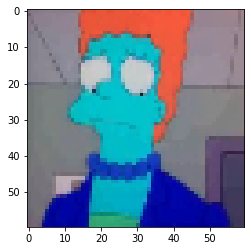

In [ ]:
plt.imshow(X_t[0]) # recordad que siempre es preferible trabajar en blanco y negro


## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [ ]:

X.shape,y,np.unique(y)




((18992, 60, 60, 3),
 array([ 6, 14,  9, ..., 17, 17, 10]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]))

In [ ]:
#Put all images to grayscale
import cv2
gX=[]
for i in X:
  gX.append(cv2.cvtColor(i,cv2.COLOR_BGR2GRAY))
gX=np.array(gX)
gX.reshape(18992,1,60,60)
gX=gX.astype("float32")
gX=gX/255

In [ ]:
y=keras.utils.to_categorical(y,18)

In [ ]:
from keras import Sequential
from keras.layers import Conv2D,Dense,Flatten

model=Sequential()
model.add(Conv2D(64,(3,3),input_shape=(60,60,1)))
model.add(Flatten())
model.add(Dense(18))




In [ ]:
model.compile(metrics=['accuracy'],loss=keras.losses.categorical_crossentropy)


In [ ]:
print(gX.shape)
model.fit(gX,y,validation_split=0.2)

(18992, 60, 60)
475/475 [==============================] - 20s 19ms/step - loss: 8.5110 - accuracy: 0.1176 - val_loss: 8.9649 - val_accuracy: 0.1150


JAVIER CÓDIGO

In [ ]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(15,10))
 
    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
 
    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
 
    plt.legend()
    plt.show()

In [ ]:
training_images  = X
training_labels = y
test_images = X_t
test_labels = y_t

In [ ]:
training_images  = training_images / 255.0
test_images = test_images / 255.0

In [ ]:
print(training_images.shape)
print(training_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(18992, 60, 60, 3)
(18992,)
(890, 60, 60, 3)
(890,)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', input_shape = (60, 60, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(18, activation = 'softmax')  
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(training_images, training_labels, batch_size = 64, epochs = 30, validation_data = (test_images,test_labels))

Epoch 1/30
297/297 [==============================] - 11s 37ms/step - loss: 2.1383 - accuracy: 0.3463 - val_loss: 1.7700 - val_accuracy: 0.4910
Epoch 2/30
297/297 [==============================] - 10s 34ms/step - loss: 1.4174 - accuracy: 0.5809 - val_loss: 1.2831 - val_accuracy: 0.6348
Epoch 3/30
297/297 [==============================] - 10s 34ms/step - loss: 1.0771 - accuracy: 0.6804 - val_loss: 0.9943 - val_accuracy: 0.7101
Epoch 4/30
297/297 [==============================] - 10s 34ms/step - loss: 0.8758 - accuracy: 0.7403 - val_loss: 0.7861 - val_accuracy: 0.7809
Epoch 5/30
297/297 [==============================] - 10s 34ms/step - loss: 0.7360 - accuracy: 0.7818 - val_loss: 0.6984 - val_accuracy: 0.8011
Epoch 6/30
297/297 [==============================] - 10s 34ms/step - loss: 0.6256 - accuracy: 0.8143 - val_loss: 0.5708 - val_accuracy: 0.8337
Epoch 7/30
297/297 [==============================] - 10s 34ms/step - loss: 0.5420 - accuracy: 0.8405 - val_loss: 0.4861 - val_accuracy:

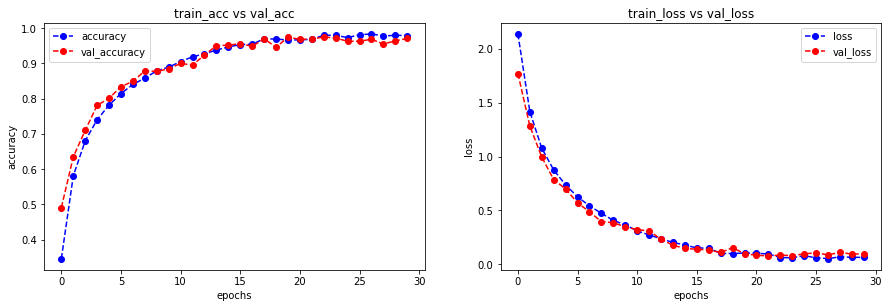

In [ ]:
plot_accuracy_loss(history)

In [ ]:
classifications = model.predict(test_images)

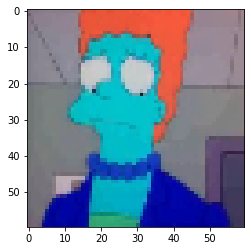

In [ ]:
plt.imshow(test_images[0])

In [ ]:
print('Posición del valor más alto:', np.argmax(classifications[0]))
print(MAP_CHARACTERS[test_labels[0]])

Posición del valor más alto: 11
marge_simpson


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (60, 60, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(18, activation = 'softmax')  
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(training_images, training_labels, batch_size = 64, epochs = 30)

In [ ]:
classifications = model.predict(test_images)

In [ ]:
print('Posición del valor más alto:', np.argmax(classifications[0]))
print(MAP_CHARACTERS[test_labels[0]])
print(MAP_CHARACTERS[classifications[0]])

## Codigo Joaquin


In [ ]:
training_images  = X
training_labels = y
test_images = X_t
test_labels = y_t

training_images  = training_images / 255.0
test_images = test_images / 255.0

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', input_shape = (60, 60, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(18, activation = 'softmax')  
])
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(training_images, training_labels, batch_size = 16, epochs = 50, validation_split=0.3)

Epoch 1/50
831/831 [==============================] - 19s 23ms/step - loss: 1.8811 - accuracy: 0.3845 - val_loss: 12.6938 - val_accuracy: 0.0205
Epoch 2/50
831/831 [==============================] - 19s 22ms/step - loss: 1.2683 - accuracy: 0.5946 - val_loss: 11.9375 - val_accuracy: 0.0388
Epoch 3/50
831/831 [==============================] - 19s 22ms/step - loss: 0.9766 - accuracy: 0.6868 - val_loss: 12.9553 - val_accuracy: 0.0519
Epoch 4/50
831/831 [==============================] - 19s 22ms/step - loss: 0.8316 - accuracy: 0.7306 - val_loss: 12.8295 - val_accuracy: 0.0560
Epoch 5/50
831/831 [==============================] - 19s 22ms/step - loss: 0.7235 - accuracy: 0.7639 - val_loss: 13.9856 - val_accuracy: 0.0551
Epoch 6/50
831/831 [==============================] - 19s 22ms/step - loss: 0.6282 - accuracy: 0.7967 - val_loss: 14.5107 - val_accuracy: 0.0555
Epoch 7/50
831/831 [==============================] - 19s 23ms/step - loss: 0.5715 - accuracy: 0.8177 - val_loss: 14.2421 - val_ac

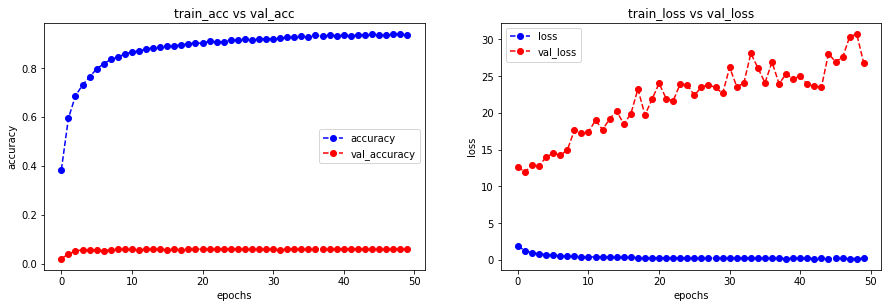

In [ ]:
plot_accuracy_loss(history)

In [ ]:
classifications = model.predict(test_images)

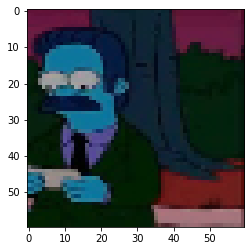

In [ ]:
plt.imshow(test_images[11])

In [ ]:
print('Posición del valor más alto:', np.argmax(classifications[0]))
print(MAP_CHARACTERS[test_labels[11]])

Posición del valor más alto: 0
ned_flanders


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', input_shape = (60, 60, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', input_shape = (60, 60, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(18, activation = 'softmax')  
])
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(training_images, training_labels, batch_size = 16, epochs = 30, validation_data = (test_images,test_labels))

Epoch 1/30
1187/1187 [==============================] - 28s 23ms/step - loss: 2.5735 - accuracy: 0.1864 - val_loss: 2.2485 - val_accuracy: 0.3191
Epoch 2/30
1187/1187 [==============================] - 27s 23ms/step - loss: 1.8516 - accuracy: 0.4232 - val_loss: 1.5414 - val_accuracy: 0.5022
Epoch 3/30
1187/1187 [==============================] - 27s 22ms/step - loss: 1.4428 - accuracy: 0.5535 - val_loss: 1.1348 - val_accuracy: 0.6416
Epoch 4/30
1187/1187 [==============================] - 27s 23ms/step - loss: 1.2316 - accuracy: 0.6189 - val_loss: 1.0396 - val_accuracy: 0.6764
Epoch 5/30
1187/1187 [==============================] - 27s 23ms/step - loss: 1.0648 - accuracy: 0.6671 - val_loss: 0.8641 - val_accuracy: 0.7303
Epoch 6/30
1187/1187 [==============================] - 27s 23ms/step - loss: 0.9628 - accuracy: 0.7025 - val_loss: 0.7979 - val_accuracy: 0.7416
Epoch 7/30
1187/1187 [==============================] - 27s 23ms/step - loss: 0.8729 - accuracy: 0.7314 - val_loss: 0.6768 -

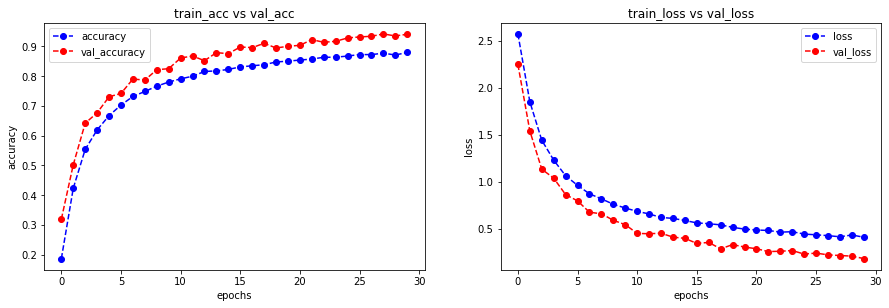

In [ ]:
plot_accuracy_loss(history)

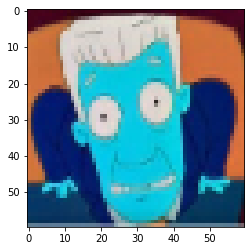

In [ ]:
plt.imshow(test_images[15])

In [ ]:
print('Posición del valor más alto:', np.argmax(classifications[15]))
print([test_labels[15]])
print(MAP_CHARACTERS[test_labels[15]])

Posición del valor más alto: 8
[8]
kent_brockman
